# 04 — Prediction Exploration

Interactive analysis of forecasting results:
- Model performance comparison
- Error analysis by district and time
- Feature importance (XGBoost/LightGBM)
- Residual diagnostics

**Prerequisites:** Run `make predict` first.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

import sys
sys.path.insert(0, str(Path.cwd().parent))
from src.config import RESULTS_DIR, extract_borough

## 1. Load Results

In [4]:
results = pd.read_parquet(RESULTS_DIR / 'prediction_results.parquet')
comparison = pd.read_csv(RESULTS_DIR / 'prediction_comparison.csv', index_col=0)

print(f"Total predictions: {len(results):,}")
print(f"Models: {results['model'].unique().tolist()}")
print(f"Districts: {results['District_Code'].nunique()}")
print(f"\nOverall comparison:")
comparison

Total predictions: 15,310
Models: ['SARIMA', 'Prophet', 'XGBoost', 'LightGBM', 'LSTM']
Districts: 59

Overall comparison:


,rmse,mae,mape,r2
model,,,,
SARIMA,29.0799,22.9440,0.4170,0.5035
Prophet,28.3399,22.3912,0.3994,0.5285
XGBoost,29.0365,23.0274,0.4341,0.5050
LightGBM,28.4851,22.5271,0.4052,0.5236
LSTM,32.1873,25.9896,0.5621,0.3917


## 2. Model Comparison

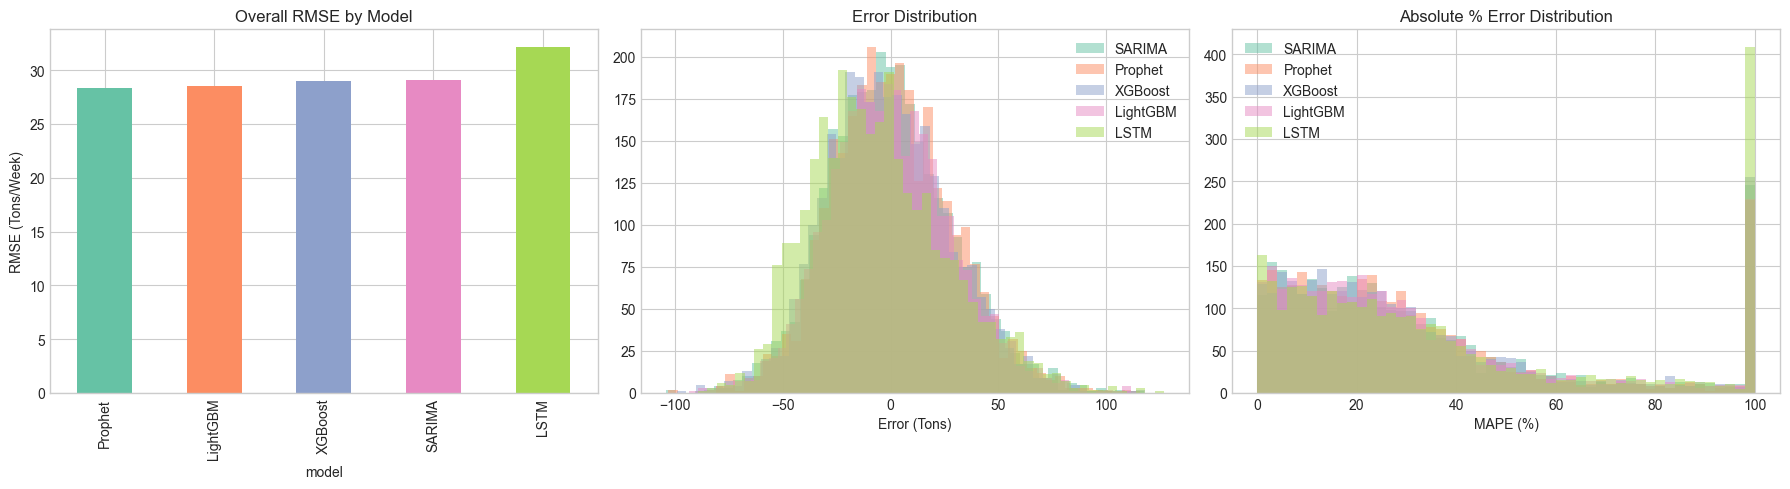

In [5]:
results['error'] = results['y_true'] - results['y_pred']
results['abs_error'] = np.abs(results['error'])
results['pct_error'] = np.where(
    results['y_true'] != 0,
    results['abs_error'] / results['y_true'] * 100,
    np.nan
)

# RMSE by model
rmse_by_model = results.groupby('model').apply(
    lambda g: np.sqrt((g['error']**2).mean()), include_groups=False
).sort_values()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE bar
rmse_by_model.plot(kind='bar', ax=axes[0], color=sns.color_palette('Set2'))
axes[0].set_title('Overall RMSE by Model')
axes[0].set_ylabel('RMSE (Tons/Week)')

# Error distribution
for model in results['model'].unique():
    subset = results[results['model'] == model]
    axes[1].hist(subset['error'].clip(-200, 200), bins=50, alpha=0.5, label=model)
axes[1].set_title('Error Distribution')
axes[1].set_xlabel('Error (Tons)')
axes[1].legend()

# MAPE distribution
for model in results['model'].unique():
    subset = results[results['model'] == model]
    axes[2].hist(subset['pct_error'].dropna().clip(0, 100), bins=50, alpha=0.5, label=model)
axes[2].set_title('Absolute % Error Distribution')
axes[2].set_xlabel('MAPE (%)')
axes[2].legend()

plt.tight_layout()
plt.show()

## 3. Forecast Plots — Top Districts

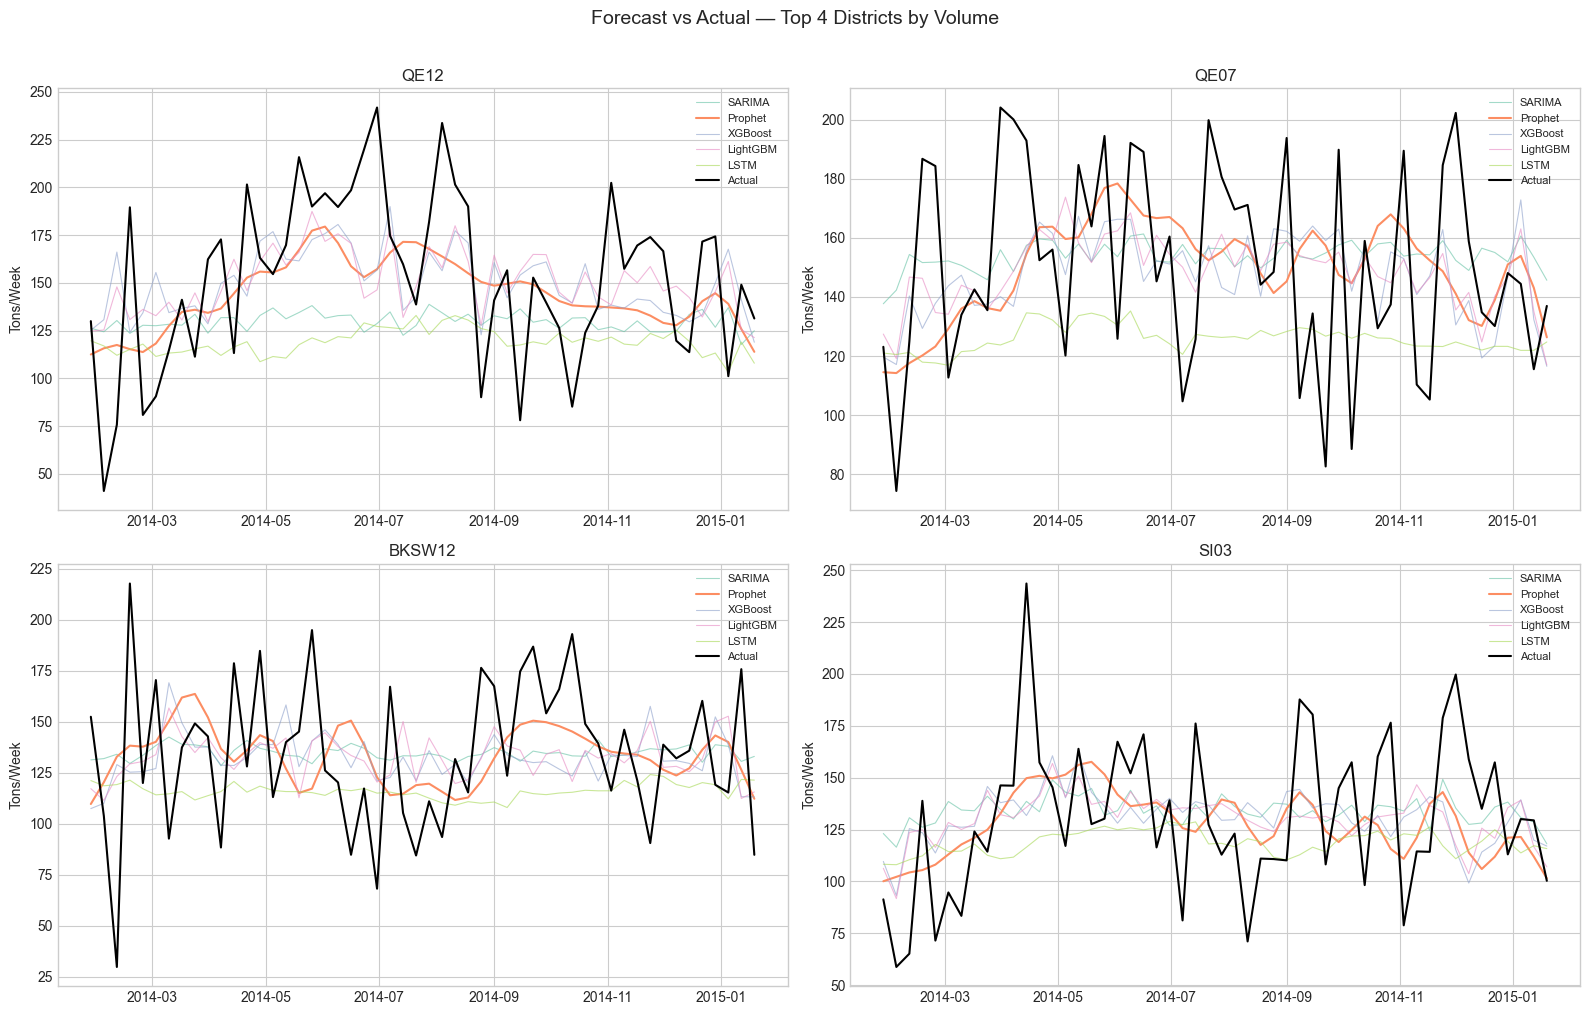

In [6]:
# Pick top 4 districts by volume
top_districts = results.groupby('District_Code')['y_true'].mean().nlargest(4).index.tolist()
best_model = comparison['rmse'].idxmin()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, district in zip(axes, top_districts):
    for model in results['model'].unique():
        subset = results[(results['model'] == model) & (results['District_Code'] == district)]
        subset = subset.sort_values('week_start')
        if model == best_model:
            ax.plot(subset['week_start'], subset['y_pred'], label=model, linewidth=1.5)
        else:
            ax.plot(subset['week_start'], subset['y_pred'], label=model, linewidth=0.8, alpha=0.6)
    
    # Actual
    actual = results[(results['model'] == best_model) & (results['District_Code'] == district)]
    ax.plot(actual['week_start'], actual['y_true'], 'k-', label='Actual', linewidth=1.5)
    ax.set_title(district)
    ax.legend(fontsize=8)
    ax.set_ylabel('Tons/Week')

plt.suptitle('Forecast vs Actual — Top 4 Districts by Volume', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

## 4. Error Analysis by District

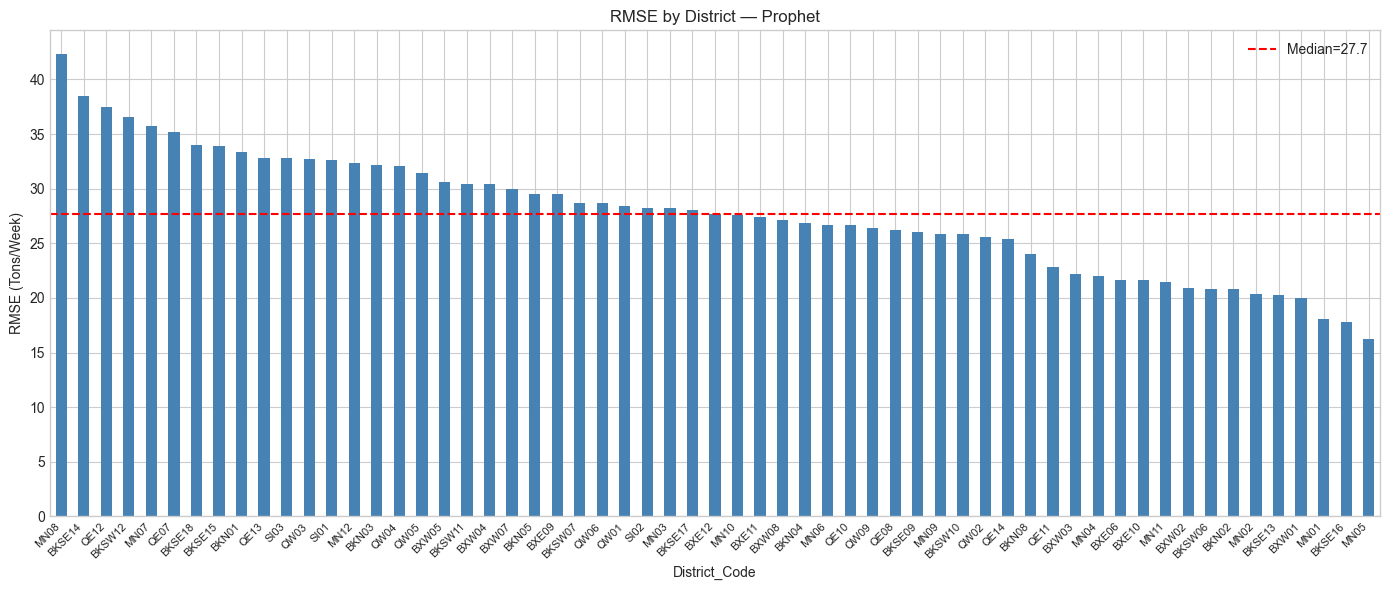

In [7]:
# Per-district RMSE for best model
best_results = results[results['model'] == best_model]
best_results = best_results.copy()
best_results['borough'] = best_results['District_Code'].apply(extract_borough)

district_rmse = best_results.groupby('District_Code').apply(
    lambda g: np.sqrt((g['error']**2).mean()), include_groups=False
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
district_rmse.plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('RMSE (Tons/Week)')
ax.set_title(f'RMSE by District — {best_model}')
ax.axhline(y=district_rmse.median(), color='red', linestyle='--', label=f'Median={district_rmse.median():.1f}')
ax.legend()
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/hq/lzl21s154sjdtgsp2dpr41y80000gp/T/ipykernel_46468/3889005563.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=borough_rmse, x='borough', y='rmse', ax=ax, palette='Set2')


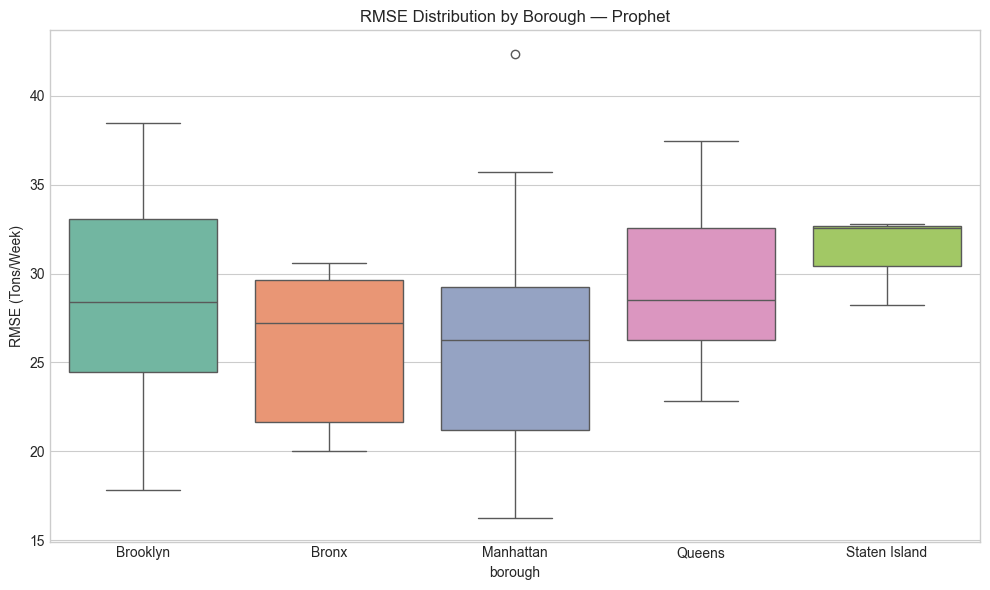

In [8]:
# RMSE box plot by borough
borough_rmse = best_results.groupby(['District_Code', 'borough']).apply(
    lambda g: np.sqrt((g['error']**2).mean()), include_groups=False
).reset_index(name='rmse')

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=borough_rmse, x='borough', y='rmse', ax=ax, palette='Set2')
ax.set_ylabel('RMSE (Tons/Week)')
ax.set_title(f'RMSE Distribution by Borough — {best_model}')
plt.tight_layout()
plt.show()

## 5. Feature Importance (XGBoost)

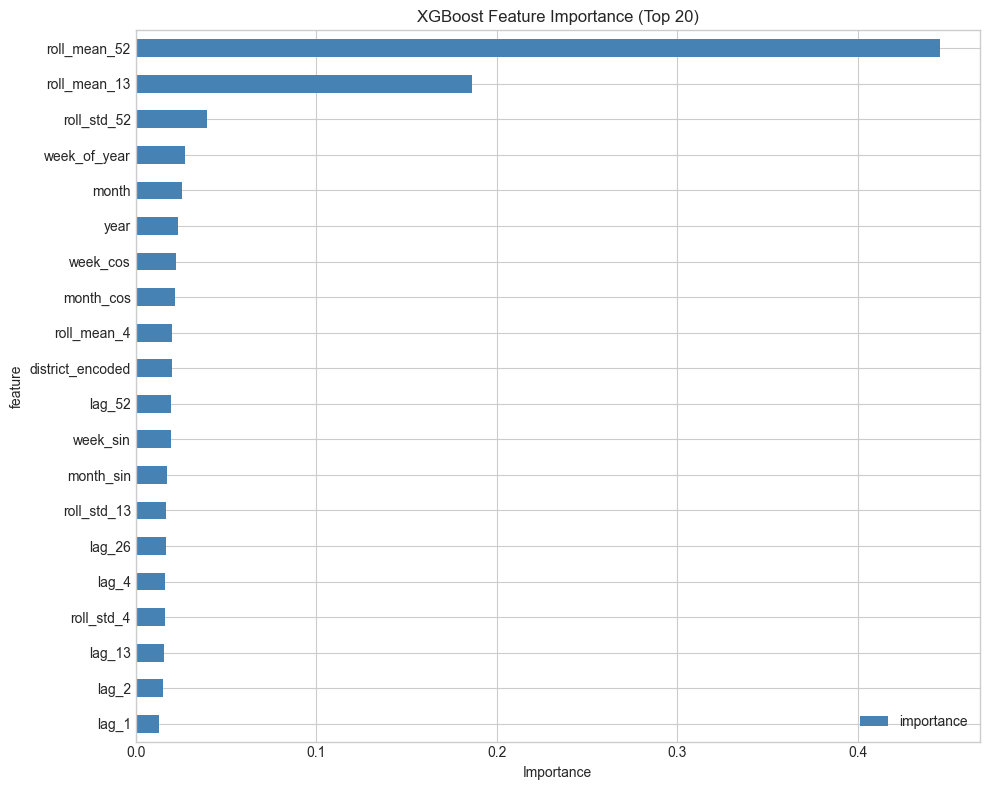

In [9]:
imp_path = RESULTS_DIR / 'xgb_feature_importance.csv'
if imp_path.exists():
    importance = pd.read_csv(imp_path)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    importance.head(20).plot(kind='barh', x='feature', y='importance', ax=ax, color='steelblue')
    ax.set_xlabel('Importance')
    ax.set_title('XGBoost Feature Importance (Top 20)')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print('No feature importance file found — run prediction pipeline first')

## 6. Residual Diagnostics

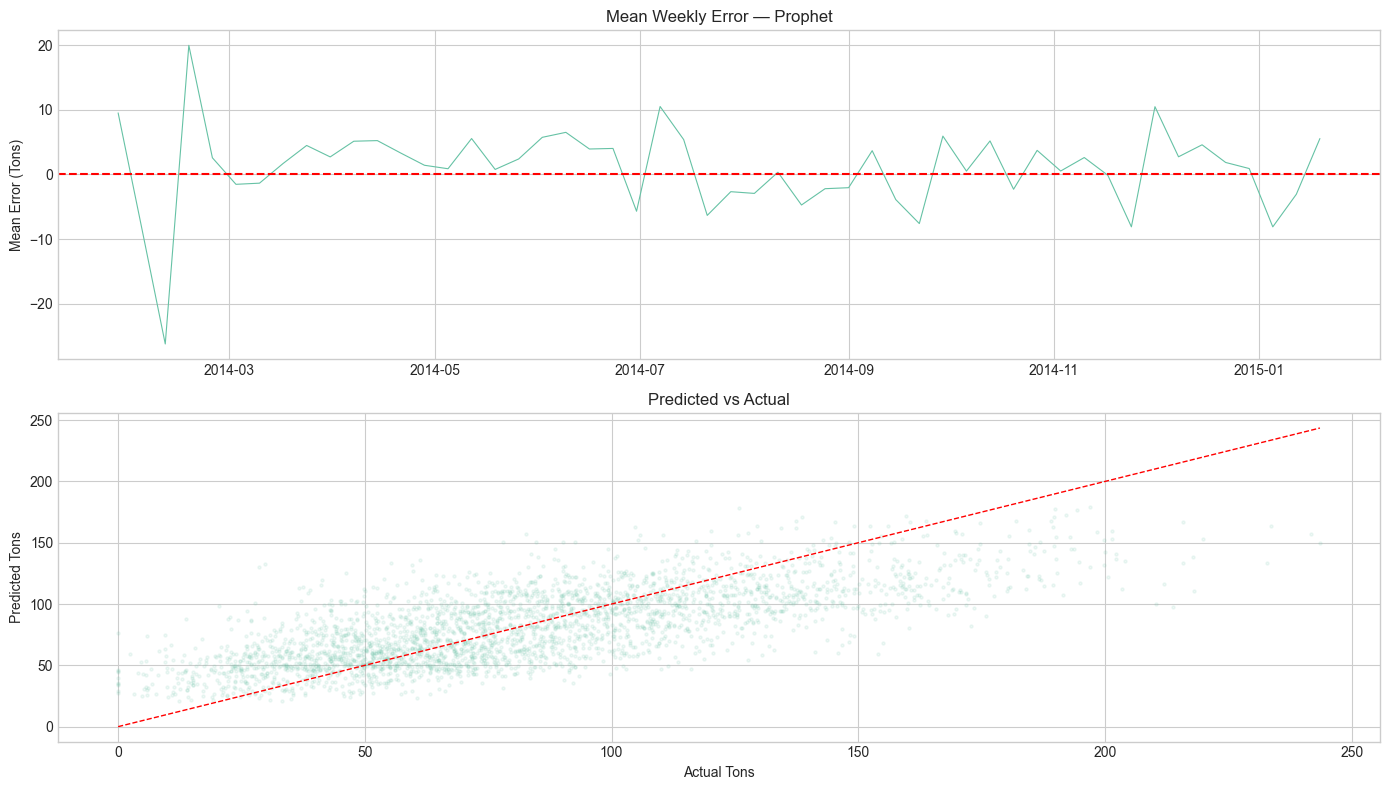

In [10]:
# Residuals over time for best model
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Residuals by week
weekly_error = best_results.groupby('week_start')['error'].mean()
axes[0].plot(weekly_error.index, weekly_error.values, linewidth=0.8)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_ylabel('Mean Error (Tons)')
axes[0].set_title(f'Mean Weekly Error — {best_model}')

# Predicted vs Actual scatter
axes[1].scatter(best_results['y_true'], best_results['y_pred'], alpha=0.1, s=5)
max_val = max(best_results['y_true'].max(), best_results['y_pred'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=1)
axes[1].set_xlabel('Actual Tons')
axes[1].set_ylabel('Predicted Tons')
axes[1].set_title('Predicted vs Actual')

plt.tight_layout()
plt.show()